In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Set base folder
base = Path("./")   # use your local folder where CSV/JSON files are stored

# File paths
patients_fp = base / "patients_data_with_doctor.csv"
doctors_fp = base / "doctors_info.csv"
feedback_fp = base / "patient_feedback.json"

# Load data
patients_raw = pd.read_csv(patients_fp)
doctors_raw = pd.read_csv(doctors_fp)
feedback_raw = pd.read_json(feedback_fp)

print("Shapes:")
print("patients:", patients_raw.shape)
print("doctors:", doctors_raw.shape)
print("feedback:", feedback_raw.shape)

patients_raw.head()


Shapes:
patients: (1000, 7)
doctors: (50, 3)
feedback: (1000, 4)


,treatment_id,patient_id,doctor_id,treatment_type,treatment_cost,room_cost,treatment_date
0,T0001,P0067,D006,part,2723.53,1932.58,2025-08-04
1,T0002,P0006,D022,machine,3963.16,2215.53,2024-09-29
2,T0003,P0637,D014,seat,4108.71,4958.21,2024-09-14
3,T0004,P0314,D003,star,4793.77,1614.28,2024-09-25
4,T0005,P0326,D012,art,4138.91,2779.05,2024-10-11


In [2]:
# Helper
def clean_strings(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
    return df

# Clean Patients
patients = clean_strings(patients_raw.copy(), ["treatment_id","patient_id","doctor_id","treatment_type"])
patients["treatment_cost"] = pd.to_numeric(patients["treatment_cost"], errors="coerce")
patients["room_cost"] = pd.to_numeric(patients["room_cost"], errors="coerce").fillna(0)
patients["treatment_cost"] = patients["treatment_cost"].fillna(patients["treatment_cost"].median())
patients["treatment_date"] = pd.to_datetime(patients["treatment_date"], errors="coerce")
patients["total_cost"] = patients["treatment_cost"] + patients["room_cost"]

# Clean Doctors
doctors = clean_strings(doctors_raw.copy(), ["doctor_id","doctor_name","specialty"]).drop_duplicates("doctor_id")

# Clean Feedback
feedback = clean_strings(feedback_raw.copy(), ["patient_id","treatment_id"])
feedback["review_date"] = pd.to_datetime(feedback["review_date"], errors="coerce")
feedback["patient_feedback_score"] = pd.to_numeric(feedback["patient_feedback_score"], errors="coerce").clip(1,5)
feedback = feedback.sort_values("review_date").drop_duplicates(["patient_id","treatment_id"], keep="last")

print("Cleaned shapes:", patients.shape, doctors.shape, feedback.shape)
patients.head()


Cleaned shapes: (1000, 8) (50, 3) (1000, 4)


,treatment_id,patient_id,doctor_id,treatment_type,treatment_cost,room_cost,treatment_date,total_cost
0,T0001,P0067,D006,part,2723.53,1932.58,2025-08-04,4656.11
1,T0002,P0006,D022,machine,3963.16,2215.53,2024-09-29,6178.69
2,T0003,P0637,D014,seat,4108.71,4958.21,2024-09-14,9066.92
3,T0004,P0314,D003,star,4793.77,1614.28,2024-09-25,6408.05
4,T0005,P0326,D012,art,4138.91,2779.05,2024-10-11,6917.96


In [3]:
# Merge patients with doctors
merged = patients.merge(doctors, on="doctor_id", how="left")

# Merge with feedback
merged = merged.merge(
    feedback[["patient_id","treatment_id","patient_feedback_score","review_date"]],
    on=["patient_id","treatment_id"], how="left"
)

# Add extra features
merged["has_feedback"] = ~merged["patient_feedback_score"].isna()
merged["treatment_month"] = merged["treatment_date"].dt.to_period("M").astype(str)

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (1000, 14)


,treatment_id,patient_id,doctor_id,treatment_type,treatment_cost,room_cost,treatment_date,total_cost,doctor_name,specialty,patient_feedback_score,review_date,has_feedback,treatment_month
0,T0001,P0067,D006,part,2723.53,1932.58,2025-08-04,4656.11,John Morales,"Scientist, clinical (histocompatibility and im...",NaN,NaT,False,2025-08
1,T0002,P0006,D022,machine,3963.16,2215.53,2024-09-29,6178.69,Brandon Byrd,"Education officer, museum",NaN,NaT,False,2024-09
2,T0003,P0637,D014,seat,4108.71,4958.21,2024-09-14,9066.92,Antonio Stone,Nutritional therapist,NaN,NaT,False,2024-09
3,T0004,P0314,D003,star,4793.77,1614.28,2024-09-25,6408.05,Daniel Frye,Metallurgist,NaN,NaT,False,2024-09
4,T0005,P0326,D012,art,4138.91,2779.05,2024-10-11,6917.96,Cynthia Rodriguez,Automotive engineer,NaN,NaT,False,2024-10


In [4]:
# Doctor-level KPIs
by_doc = (
    merged.groupby(["doctor_id","doctor_name","specialty"])
    .agg(
        treatments=("treatment_id","nunique"),
        total_revenue=("total_cost","sum"),
        avg_treatment_cost=("total_cost","mean"),
        feedback_cov=("has_feedback","mean"),
        avg_feedback=("patient_feedback_score","mean")
    )
    .reset_index()
    .sort_values("total_revenue", ascending=False)
)

# Treatment-type KPIs
by_type = (
    merged.groupby("treatment_type")
    .agg(
        treatments=("treatment_id","nunique"),
        total_revenue=("total_cost","sum"),
        avg_cost=("total_cost","mean")
    )
    .reset_index()
    .sort_values("total_revenue", ascending=False)
)

# Monthly KPIs
by_month = (
    merged.groupby("treatment_month")
    .agg(
        treatments=("treatment_id","nunique"),
        total_revenue=("total_cost","sum"),
        avg_feedback=("patient_feedback_score","mean")
    )
    .reset_index()
)

print("Top 5 Doctors by Revenue:")
print(by_doc.head())


Top 5 Doctors by Revenue:
   doctor_id        doctor_name                     specialty  treatments  \
38      D039      Gabriel Stone  Medical sales representative          31   
41      D042      Brooke Levine                  Retail buyer          28   
17      D018   Claudia Robinson      Advertising art director          24   
39      D040          Lisa Gray                Health visitor          20   
11      D012  Cynthia Rodriguez           Automotive engineer          24   

    total_revenue  avg_treatment_cost  feedback_cov  avg_feedback  
38      160905.05         5190.485484           0.0           NaN  
41      159369.34         5691.762143           0.0           NaN  
17      134953.36         5623.056667           0.0           NaN  
39      132596.89         6629.844500           0.0           NaN  
11      131264.42         5469.350833           0.0           NaN  


In [5]:
# Patient-level features
patient_feats = (
    merged.groupby("patient_id")
    .agg(
        total_spend=("total_cost","sum"),
        visit_count=("treatment_id","nunique"),
        avg_feedback=("patient_feedback_score","mean"),
        last_visit=("treatment_date","max")
    )
    .reset_index()
)

# Recency in days
max_date = merged["treatment_date"].max()
patient_feats["recency_days"] = (max_date - patient_feats["last_visit"]).dt.days

# Fill missing feedback with overall mean
overall_fb = merged["patient_feedback_score"].mean()
patient_feats["avg_feedback"] = patient_feats["avg_feedback"].fillna(overall_fb)

# VIP = top 20% spenders
threshold = patient_feats["total_spend"].quantile(0.80)
patient_feats["VIP_status"] = np.where(patient_feats["total_spend"]>=threshold, "VIP","Regular")

print("VIP threshold:", threshold)
patient_feats.head()


VIP threshold: 12528.604


,patient_id,total_spend,visit_count,avg_feedback,last_visit,recency_days,VIP_status
0,P0001,8175.59,1,NaN,2024-12-12,244,Regular
1,P0002,12952.30,3,NaN,2025-05-04,101,VIP
2,P0006,6178.69,1,NaN,2024-09-29,318,Regular
3,P0007,8665.51,2,NaN,2025-07-17,27,Regular
4,P0009,5367.34,1,NaN,2024-12-22,234,Regular


In [6]:
merged_with_vip = merged.merge(patient_feats[["patient_id","VIP_status"]], on="patient_id", how="left")
merged_with_vip.head()


,treatment_id,patient_id,doctor_id,treatment_type,treatment_cost,room_cost,treatment_date,total_cost,doctor_name,specialty,patient_feedback_score,review_date,has_feedback,treatment_month,VIP_status
0,T0001,P0067,D006,part,2723.53,1932.58,2025-08-04,4656.11,John Morales,"Scientist, clinical (histocompatibility and im...",NaN,NaT,False,2025-08,Regular
1,T0002,P0006,D022,machine,3963.16,2215.53,2024-09-29,6178.69,Brandon Byrd,"Education officer, museum",NaN,NaT,False,2024-09,Regular
2,T0003,P0637,D014,seat,4108.71,4958.21,2024-09-14,9066.92,Antonio Stone,Nutritional therapist,NaN,NaT,False,2024-09,Regular
3,T0004,P0314,D003,star,4793.77,1614.28,2024-09-25,6408.05,Daniel Frye,Metallurgist,NaN,NaT,False,2024-09,Regular
4,T0005,P0326,D012,art,4138.91,2779.05,2024-10-11,6917.96,Cynthia Rodriguez,Automotive engineer,NaN,NaT,False,2024-10,VIP


In [7]:
print("Top 5 Doctors by Revenue:")
print(by_doc.head(5))

print("\nTop Treatment Types:")
print(by_type.head(5))

print("\nMonthly Revenue Trend:")
print(by_month)

vip_count = (patient_feats["VIP_status"]=="VIP").sum()
print(f"\nVIP Customers: {vip_count} out of {patient_feats.shape[0]} "
      f"({vip_count/patient_feats.shape[0]*100:.1f}%)")


Top 5 Doctors by Revenue:
   doctor_id        doctor_name                     specialty  treatments  \
38      D039      Gabriel Stone  Medical sales representative          31   
41      D042      Brooke Levine                  Retail buyer          28   
17      D018   Claudia Robinson      Advertising art director          24   
39      D040          Lisa Gray                Health visitor          20   
11      D012  Cynthia Rodriguez           Automotive engineer          24   

    total_revenue  avg_treatment_cost  feedback_cov  avg_feedback  
38      160905.05         5190.485484           0.0           NaN  
41      159369.34         5691.762143           0.0           NaN  
17      134953.36         5623.056667           0.0           NaN  
39      132596.89         6629.844500           0.0           NaN  
11      131264.42         5469.350833           0.0           NaN  

Top Treatment Types:
    treatment_type  treatments  total_revenue   avg_cost
443       resource      

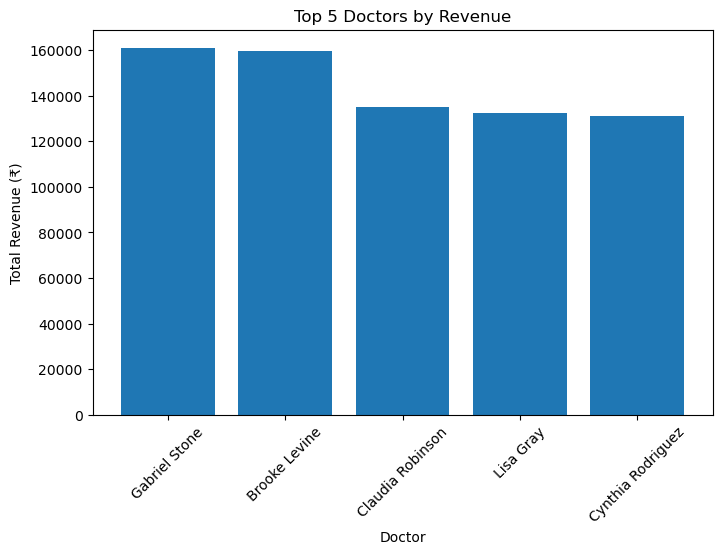

In [8]:
import matplotlib.pyplot as plt

top5_docs = by_doc.head(5)

plt.figure(figsize=(8,5))
plt.bar(top5_docs["doctor_name"], top5_docs["total_revenue"])
plt.title("Top 5 Doctors by Revenue")
plt.xlabel("Doctor")
plt.ylabel("Total Revenue (₹)")
plt.xticks(rotation=45)
plt.show()


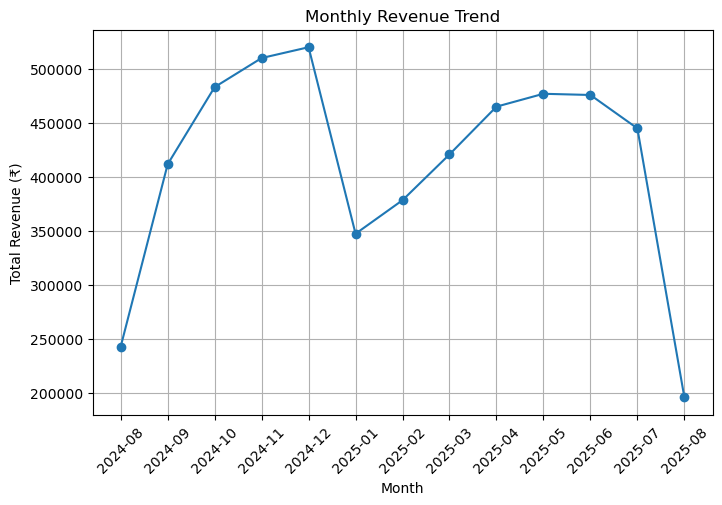

In [9]:
plt.figure(figsize=(8,5))
plt.plot(by_month["treatment_month"], by_month["total_revenue"], marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


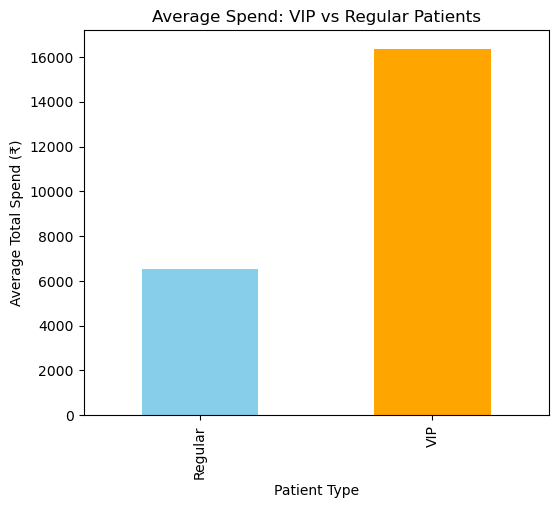

In [10]:
avg_spend = patient_feats.groupby("VIP_status")["total_spend"].mean()

plt.figure(figsize=(6,5))
avg_spend.plot(kind="bar", color=["skyblue","orange"])
plt.title("Average Spend: VIP vs Regular Patients")
plt.ylabel("Average Total Spend (₹)")
plt.xlabel("Patient Type")
plt.show()
